In [50]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [51]:
ties_df = pd.read_excel("TIESv4-1.xls")
cow_df = pd.read_csv("COW-country-codes.csv")
plty_df = pd.read_excel("POLITY5-PRC.xlsx")

In [52]:
# Identify columns that are years
year_columns = [col for col in plty_df.columns if col.isdigit()]

# Melt the entire Polity dataset (no filtering by Indicator)
melted_df_auto = plty_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='Value'
)

# Convert Year and Value to numeric and drop missing
melted_df_auto['Year'] = pd.to_numeric(melted_df_auto['Year'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Year'])
melted_df_auto['Year'] = melted_df_auto['Year'].astype(int)

melted_df_auto['Value'] = pd.to_numeric(melted_df_auto['Value'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Value'])

# Standardize country names
def safe_upper_strip(x):
    if isinstance(x, str):
        return x.upper().strip()
    return np.nan

melted_df_auto['Economy_Name_standardized'] = melted_df_auto['Economy Name'].apply(safe_upper_strip)
cow_df['StateNme_standardized'] = cow_df['StateNme'].apply(safe_upper_strip)

melted_df_auto = melted_df_auto.dropna(subset=['Economy_Name_standardized'])
cow_df = cow_df.dropna(subset=['StateNme_standardized'])

# Map countries to their CCode
country_mapping = dict(zip(cow_df['StateNme_standardized'], cow_df['CCode']))
melted_df_auto['Country_Code'] = melted_df_auto['Economy_Name_standardized'].map(country_mapping)
melted_df_auto = melted_df_auto.dropna(subset=['Country_Code'])
melted_df_auto['Country_Code'] = melted_df_auto['Country_Code'].astype(int)

melted_df_auto = melted_df_auto[~(
    (melted_df_auto['Indicator'] == 'Polity database: Combined Polity Score') &
    ((melted_df_auto['Value'] < -10) | (melted_df_auto['Value'] > 10))
)]

# Ensure ties_df has numeric Country_Code and year
ties_df['Country_Code'] = pd.to_numeric(ties_df['targetstate'], errors='coerce')
ties_df = ties_df.dropna(subset=['Country_Code'])
ties_df['Country_Code'] = ties_df['Country_Code'].astype(int)

ties_df['startyear'] = pd.to_numeric(ties_df['startyear'], errors='coerce')
ties_df = ties_df.dropna(subset=['startyear'])
ties_df['startyear'] = ties_df['startyear'].astype(int)

# Pivot to get a multi-level column structure: columns = Indicator, Year
polity_wide = melted_df_auto.pivot_table(
    index='Country_Code', 
    columns=['Indicator','Year'], 
    values='Value'
)

# Define year offsets
year_offsets = range(-20, 21)

# For each row in ties_df, we extract polity scores for all indicators and all offsets
def get_polity_scores_for_row(row):
    ccode = row['Country_Code']
    event_year = row['startyear']
    if ccode not in polity_wide.index:
        # No polity data for this country
        return [np.nan] * (len(polity_wide.columns.levels[0]) * len(year_offsets))
    
    country_data = polity_wide.loc[ccode]
    all_values = []
    
    # Loop over each indicator
    for indicator in polity_wide.columns.levels[0]:
        # Get just this indicator's time series
        indicator_series = country_data[indicator]
        years_to_extract = [event_year + off for off in year_offsets]
        extracted = indicator_series.reindex(years_to_extract)
        all_values.extend(extracted.values)
    
    return all_values

# Create column names for all indicators and offsets
indicator_names = polity_wide.columns.levels[0]
all_columns = []
for ind in indicator_names:
    for offset in year_offsets:
        all_columns.append(f"{ind}_{offset}")

polity_scores = ties_df.apply(get_polity_scores_for_row, axis=1)
polity_scores_df = pd.DataFrame(polity_scores.tolist(), columns=all_columns, index=ties_df.index)

# Concatenate these columns with the original ties_df
final_df = pd.concat([ties_df, polity_scores_df], axis=1)

In [ ]:
final_df = final_df[final_df['startyear'] >= 1960]


### Broad Freq Analysis with Autocracy

Average Polity database: Combined Polity Score (-1 year): 4.8584905660377355


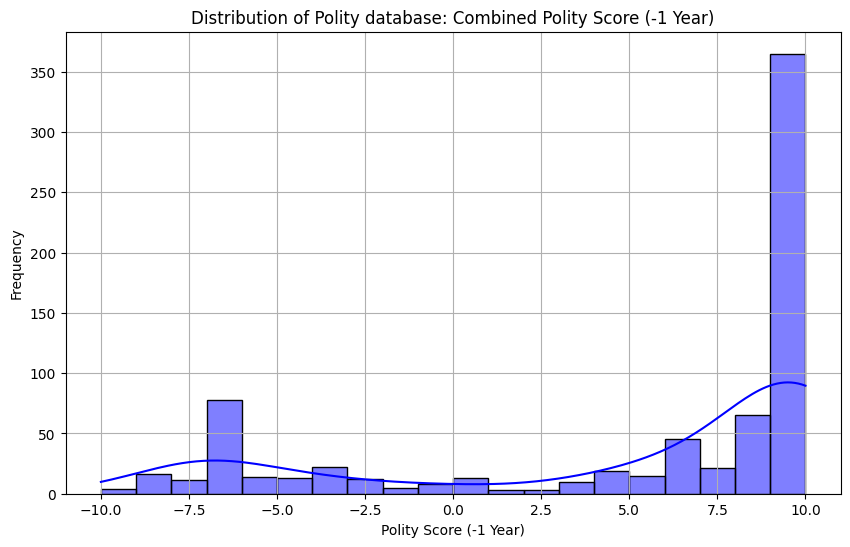

In [56]:
# Make a copy of the final_df before analysis to preserve the original
analysis_df = final_df.copy()

# 1. Calculate the average score at -1 year
mean_score = analysis_df['Polity database: Combined Polity Score_-1'].mean()
print("Average Polity database: Combined Polity Score (-1 year):", mean_score)

# 2. Show the distribution
scores = analysis_df['Polity database: Combined Polity Score_-1'].dropna()

# Make a copy of scores if you plan to do further analysis on it
scores_for_plot = scores.copy()

plt.figure(figsize=(10, 6))
sns.histplot(scores_for_plot, kde=True, bins=20, color='blue')
plt.title("Distribution of Polity database: Combined Polity Score (-1 Year)")
plt.xlabel("Polity Score (-1 Year)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

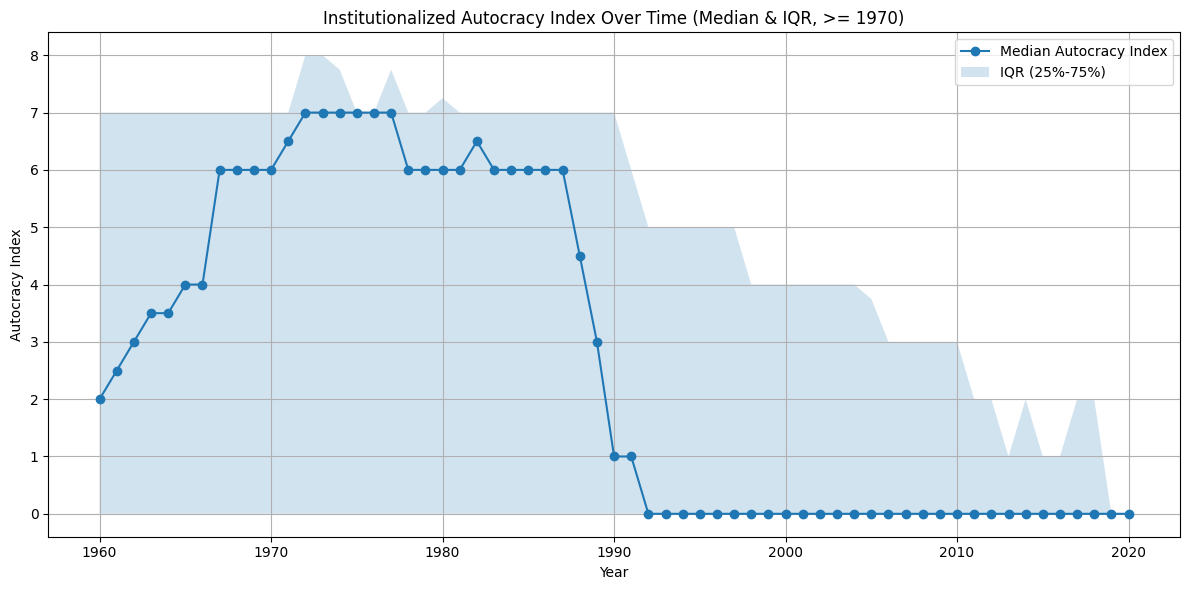

In [67]:
# Make a copy of the original DataFrame
analysis_df = plty_df.copy()

# Filter for the Institutionalized Autocracy Index
autoc_df = analysis_df[analysis_df['Indicator'] == 'Polity database: Institutionalized Autocracy Index']

# Identify year columns
year_columns = [col for col in autoc_df.columns if col.isdigit()]

# Melt into long format
melted_autoc = autoc_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='AutocracyIndex'
)

# Convert columns to numeric
melted_autoc['Year'] = pd.to_numeric(melted_autoc['Year'], errors='coerce')
melted_autoc['AutocracyIndex'] = pd.to_numeric(melted_autoc['AutocracyIndex'], errors='coerce')
melted_autoc = melted_autoc.dropna(subset=['AutocracyIndex', 'Year'])

# Exclude data before 1970
melted_autoc = melted_autoc[melted_autoc['Year'] >= 1960]

# Group by year and calculate median and IQR
yearly_stats = melted_autoc.groupby('Year')['AutocracyIndex'].agg(median='median')
yearly_stats['Q1'] = melted_autoc.groupby('Year')['AutocracyIndex'].quantile(0.25)
yearly_stats['Q3'] = melted_autoc.groupby('Year')['AutocracyIndex'].quantile(0.75)

# Plot the median line and shading for IQR
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats['median'], marker='o', label='Median Autocracy Index')
plt.fill_between(yearly_stats.index, yearly_stats['Q1'], yearly_stats['Q3'], alpha=0.2, label='IQR (25%-75%)')

plt.title('Institutionalized Autocracy Index Over Time (Median & IQR, >= 1970)')
plt.xlabel('Year')
plt.ylabel('Autocracy Index')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

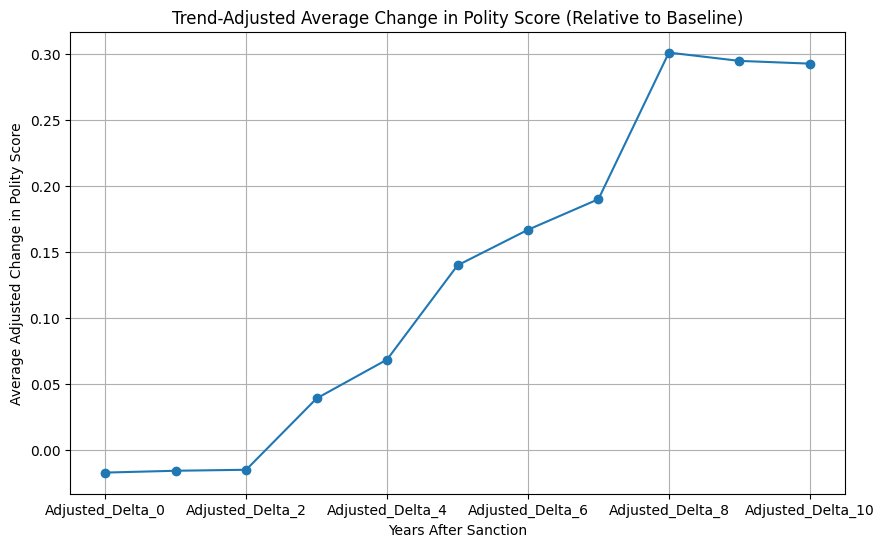

In [58]:
# Make a copy for analysis
analysis_df = final_df.copy()
indicator_name = "Polity database: Combined Polity Score"
baseline_col = f"{indicator_name}_-1"
years_post_sanction = range(0, 11)  # 0 through 10 years after the sanction

# Drop rows without a baseline value
analysis_df = analysis_df.dropna(subset=[baseline_col])

# Calculate deltas for each observation
for y in years_post_sanction:
    year_col = f"{indicator_name}_{y}"
    if year_col in analysis_df.columns:
        analysis_df[f"Delta_{y}"] = analysis_df[year_col] - analysis_df[baseline_col]

# Compute global averages at baseline and at each offset
# Include only rows that have these columns to get a consistent sample
required_cols = [baseline_col] + [f"{indicator_name}_{y}" for y in years_post_sanction if f"{indicator_name}_{y}" in analysis_df.columns]
global_df = analysis_df.dropna(subset=required_cols)

# Global average baseline
global_baseline_mean = global_df[baseline_col].mean()

# Global average for each offset year
global_means = {}
for y in years_post_sanction:
    year_col = f"{indicator_name}_{y}"
    if year_col in global_df.columns:
        global_means[y] = global_df[year_col].mean()

# Compute global deltas from baseline (this represents overall trend)
global_deltas = {y: (global_means[y] - global_baseline_mean) for y in global_means}

# Adjust each country's delta by subtracting the global delta
for y in years_post_sanction:
    delta_col = f"Delta_{y}"
    if delta_col in analysis_df.columns and y in global_deltas:
        analysis_df[f"Adjusted_{delta_col}"] = analysis_df[delta_col] - global_deltas[y]

# Now we have Adjusted_Delta_0 through Adjusted_Delta_10 columns representing the trend-adjusted changes
adjusted_delta_cols = [f"Adjusted_Delta_{y}" for y in years_post_sanction if f"Adjusted_Delta_{y}" in analysis_df.columns]

# Compute the average adjusted deltas
avg_adjusted_deltas = analysis_df[adjusted_delta_cols].mean()

# Plot the trend-controlled changes
plt.figure(figsize=(10,6))
avg_adjusted_deltas.plot(marker='o')
plt.title("Trend-Adjusted Average Change in Polity Score (Relative to Baseline)")
plt.xlabel("Years After Sanction")
plt.ylabel("Average Adjusted Change in Polity Score")
plt.grid(True)
plt.show()

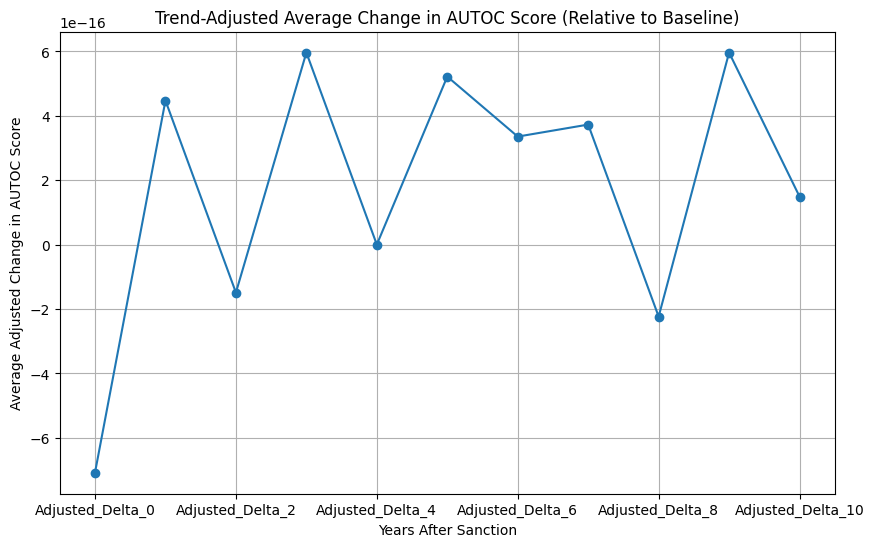

In [60]:
# Make a copy of final_df for analysis
analysis_df = final_df.copy()

# Use the AUTOC score as the indicator
indicator_name = "Polity database: Institutionalized Autocracy Index"  # Adjust if your columns differ, e.g., "Polity database: Institutionalized Autocracy Index"
baseline_col = f"{indicator_name}_-1"
years_post_sanction = range(0, 11)  # 0 through 10 years after the sanction

# Drop rows without a baseline value
analysis_df = analysis_df.dropna(subset=[baseline_col])

# Calculate deltas for each observation (difference from baseline year)
for y in years_post_sanction:
    year_col = f"{indicator_name}_{y}"
    if year_col in analysis_df.columns:
        analysis_df[f"Delta_{y}"] = analysis_df[year_col] - analysis_df[baseline_col]

# Determine the columns required for calculating global trends
required_cols = [baseline_col] + [f"{indicator_name}_{y}" for y in years_post_sanction if f"{indicator_name}_{y}" in analysis_df.columns]

# Create a global_df with no missing data in required columns
global_df = analysis_df.dropna(subset=required_cols)

# Compute the global average baseline
global_baseline_mean = global_df[baseline_col].mean()

# Compute the global average for each offset year
global_means = {}
for y in years_post_sanction:
    year_col = f"{indicator_name}_{y}"
    if year_col in global_df.columns:
        global_means[y] = global_df[year_col].mean()

# Compute global deltas (overall trend)
global_deltas = {y: (global_means[y] - global_baseline_mean) for y in global_means}

# Adjust each country's delta by subtracting the global delta to control for overall trends
for y in years_post_sanction:
    delta_col = f"Delta_{y}"
    if delta_col in analysis_df.columns and y in global_deltas:
        analysis_df[f"Adjusted_{delta_col}"] = analysis_df[delta_col] - global_deltas[y]

# Identify the columns for adjusted deltas
adjusted_delta_cols = [f"Adjusted_{y}" for y in [f"Delta_{i}" for i in years_post_sanction] if f"Adjusted_{y}" in analysis_df.columns]

# Compute the average adjusted deltas
avg_adjusted_deltas = analysis_df[adjusted_delta_cols].mean()

# Plot the trend-controlled changes in AUTOC score
plt.figure(figsize=(10,6))
avg_adjusted_deltas.plot(marker='o')
plt.title("Trend-Adjusted Average Change in AUTOC Score (Relative to Baseline)")
plt.xlabel("Years After Sanction")
plt.ylabel("Average Adjusted Change in AUTOC Score")
plt.grid(True)
plt.show()